
# Introduction

#### - This notebook explores a novel convolutional network architechture as discussed in the following research paper to build a classification system for better assistance in diagonosing Acute Lymphoblastic Leukemia in blood cells.
**[Research Paper](http://www.ijcte.org/vol10/1198-H0012.pdf)**


#### - The dataset has been taken from : [Link](https://homes.di.unimi.it/scotti/all/)

* Here, ALL_IDB2 version of the dataset has been used

* This dataset is completely balanced with equal number of samples in both the classes.


#### - Data augmentation ensures that data is large enough and model extracts features efficiently without overfitting and therefore we have analysed two types of data augmentation techniques in this notebook
* A particular type of GAN called [SinGAN](https://arxiv.org/pdf/1905.01164.pdf) was used alongwith the following techniques mentioned in the research paper:

   1. Grayscaling of image
   2. Horizontal reflection
   3. Vertical reflection
   4. Gaussian Blurring
   5. Histogram Equalization
   6. Rotation
   7. Translation
   8. Shearing

* SinGAN without the above techniques

**The dataset was split into 80% and 20% for training and testing respectively.**

#### - The details of methodologies and results of our present analysis is present [here](https://docs.google.com/document/d/11XXjFRofXlyNGcE_plRDMO4xjxELFnkVqGtBEGomL2k/edit?usp=sharing)
#### - It is also worth noting the biases present in our methodology, ethical concerns and qualititaive interpretation of our results, mentioned in the doc



#### Below is the detailed code implementation.



### Loading requires packages




In [3]:
!pip install keras_metrics

In [0]:
from pathlib import Path
import glob
import random
import cv2
from numpy.random import seed
from tensorflow import set_random_seed
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy import ndimage
from skimage import exposure
import skimage
from skimage import io
from skimage import transform as tm
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import keras
from keras.utils import np_utils
from keras.models import Model,Sequential
from keras.layers import Dense,Flatten,Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Input,GaussianNoise
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
import keras_metrics
import matplotlib.pyplot as plt
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import confusion_matrix,precision_score,recall_score
from sklearn.metrics import roc_auc_score
from keras import backend as K
%matplotlib inline

In [0]:
# for consistemt results across multiple executions
seed(3)
set_random_seed(3)

In [6]:
print(keras.__version__)
print(tf.__version__)

2.2.5
1.15.0


In [7]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
path = 'gdrive/My Drive/ALL_GAN_Dataset/'
test = Path(path+'test')
test_images = test.glob("*.tif")
train = Path(path+'train')
train_images = train.glob("*.tif")

##### The following code snippet is to seperately read test and train data, for cases where we do not want to augment test data


In [11]:
test_data = []
train_data = []

for img in test_images:
  name, ext = os.path.splitext(os.path.basename(img))
  if name[-1]=='1':
    test_data.append((img,1))
  elif name[-1]=='0':
    test_data.append((img,0))

for image in train_images:
  name, ext = os.path.splitext(os.path.basename(image))
  if name[-1]=='1':
    train_data.append((image,1))
  elif name[-1]=='0':
    train_data.append((image,0))

test_data = pd.DataFrame(test_data,columns=['image','label'],index = None)
test_data = test_data.sample(frac=1.).reset_index(drop=True)

train_data = pd.DataFrame(train_data,columns=['image','label'],index = None)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

test_data.head()

,image,label
0,gdrive/My Drive/ALL_GAN_Dataset/test/Im017_1.tif,1
1,gdrive/My Drive/ALL_GAN_Dataset/test/Im148_0.tif,0
2,gdrive/My Drive/ALL_GAN_Dataset/test/Im208_0.tif,0
3,gdrive/My Drive/ALL_GAN_Dataset/test/Im011_1.tif,1
4,gdrive/My Drive/ALL_GAN_Dataset/test/Im071_1.tif,1


##### The following code is for cases where we want to augment the test data as well. Here train-test split is performed after whole data is augmented


In [0]:
data = []

for img in test_images:
  name, ext = os.path.splitext(os.path.basename(img))
  if name[6]=='1':
    data.append((img,1))
  elif name[6]=='0':
    data.append((img,0))

for image in train_images:
  name, ext = os.path.splitext(os.path.basename(image))
  if name[-1]=='1':
    data.append((image,1))
  elif name[-1]=='0':
    data.append((image,0))

data = pd.DataFrame(data,columns=['image','label'],index = None)
data = data.sample(frac=1.).reset_index(drop=True) 

## Data Exploration and Augmentation as presented in the paper

### 8 augmentation techniques have been used here
1. Grayscaling of image
2. Horizontal reflection 
3. Vertical reflection
4. Gaussian Blurring 
5. Histogram Equalization
6. Rotation
7. Translation
8. Shearing

In [0]:
# histogram equalization function
def hist(img):
  
  img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
  hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
  return hist_equalization_result
 


In [0]:
# function to perform rotation on an image
def rotation(img):
  rows,cols = img.shape[0],img.shape[1]
  randDeg = random.randint(-180, 180)
  matrix = cv2.getRotationMatrix2D((cols/2, rows/2), randDeg, 0.70)
  rotated = cv2.warpAffine(img, matrix, (rows, cols), borderMode=cv2.BORDER_CONSTANT,
                                     borderValue=(144, 159, 162))
  return rotated     

In [0]:
# function to perform shearing of an image
def shear(img):
  # Create Afine transform
  afine_tf = tm.AffineTransform(shear=0.5)

  # Apply transform to image data
  modified = tm.warp(img, inverse_map=afine_tf)
  
  return modified

In [0]:
def aug_method(dataframe,dim,method):
  if method == 'paper':
    
    n = len(dataframe)

    data = np.zeros((n*6,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n*6,2),dtype = np.float32)


    count = 0


    for j in range(0,n):

      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']

      encoded_label = np_utils.to_categorical(label, num_classes=2)

      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))

      if img.shape[2]==1:

        img = np.dstack([img, img, img])



      orig_img = img.astype(np.float32)/255.

      data[count] = orig_img
      labels[count] = encoded_label

      # Cases where we also use SinGAN as a data augmentation technique, only 5 out of the above 8 have been used.
      
      aug_img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      aug_img2 = cv2.flip(img, 0) 
      #aug_img3 = cv2.flip(img,1)
      #aug_img4 = ndimage.gaussian_filter(img, sigma= 5.11)
      aug_img5 = hist(img)
      aug_img6 = rotation(img)
      aug_img7 = cv2.warpAffine(img, np.float32([[1, 0, 84], [0, 1, 56]]), (img.shape[0], img.shape[1]),
                                  borderMode=cv2.BORDER_CONSTANT, borderValue=(144, 159, 162))
      #aug_img8 = shear(img)

      aug_img1 = np.dstack([aug_img1, aug_img1, aug_img1])


      aug_img1 = aug_img1.astype(np.float32)/255.                 
      aug_img2 = aug_img2.astype(np.float32)/255.
      #aug_img3 = aug_img3.astype(np.float32)/255. 
      #aug_img4 = aug_img4.astype(np.float32)/255.
      aug_img5 = aug_img5.astype(np.float32)/255.
      aug_img6 = aug_img6.astype(np.float32)/255.
      aug_img7 = aug_img7.astype(np.float32)/255.
      #aug_img8 = aug_img8.astype(np.float32)/255.

      data[count+1] = aug_img1
      labels[count+1] = encoded_label
      data[count+2] = aug_img2
      labels[count+2] = encoded_label
      data[count+3] = aug_img5
      labels[count+3] = encoded_label
      data[count+4] = aug_img6
      labels[count+4] = encoded_label
      data[count+5] = aug_img7
      labels[count+5] = encoded_label
      #data[count+6] = aug_img5
      #labels[count+6] = encoded_label
      #data[count+7] = aug_img5
      #labels[count+7] = encoded_label
      #data[count+8] = aug_img5
      #labels[count+8] = encoded_label

      count +=6
      
  elif method == 'keras':
    n = len(dataframe)
  
    data = np.zeros((n,dim,dim,3),dtype = np.float32)
    labels = np.zeros((n,2),dtype = np.float32)
  
  
    count = 0
  
    
    for j in range(0,n):
    
      img_name = dataframe.iloc[j]['image']
      label = dataframe.iloc[j]['label']
      
      encoded_label = np_utils.to_categorical(label, num_classes=2)
            
      img = cv2.imread(str(img_name))
      img = cv2.resize(img, (dim,dim))
      
      if img.shape[2]==1:
     
        img = np.dstack([img, img, img])
                        
    
            
      orig_img = img.astype(np.float32)/255.
                        
      data[count] = orig_img
      labels[count] = encoded_label
    
      count +=1
    
    
                      
      
  return data,labels                  

In [0]:
'''Both train and test set (already augmented with SinGAN) augmented with 5 augmentation methods as discussed in the paper'''
data,labels = aug_method(data,dim=100,method='paper')

''' Train and test set , augmented with SinGAN only'''
#data,labels = aug_method(data,dim=100,method='keras')


print('Shape of full dataset:', data.shape)
data = np.asarray(data)
labels = np.asarray(labels)
Data,Label = shuffle(data,labels, random_state=3)
data_list = [Data,Label]


(X, y) = (data_list[0],data_list[1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

print('Shape of training data:',X_train.shape)
print('Shape of test data:',X_test.shape)


In [0]:
''' Train set augmented with SinGAN and data augmentation techniques discussed above, and test set not augmented at all'''
X_train,y_train = aug_method(train_data,dim=100,method='paper')
X_test,y_test = aug_method(test_data,dim=100,method='keras')

''' Train set augmented with SinGAN only, test set not augmented'''
#X_train,y_train = aug_method(train_data,dim=100,method='keras')
#X_test,y_test = aug_method(test_data,dim=100,method='keras')

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

print('Shape of training data:',X_train.shape)
print('Shape of test data:',X_test.shape)




###**The following model was used in the paper**
Additionaly three dropout layers with different dropout rates have been used to reduce overfitting

In [0]:
model = Sequential()
model.add(Conv2D(16,(5,5),padding='valid',input_shape = X_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.4))

model.add(Conv2D(32,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'valid'))
model.add(Dropout(0.6))

model.add(Conv2D(64,(5,5),padding='valid'))
model.add(Activation('relu'))
model.add(Dropout(0.8))

model.add(Flatten())
model.add(Dense(2,activation = 'softmax'))









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        1216      
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        12832     
_________________________________________________________________
activation_2 (Activation)    (None, 44, 44, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 32)       

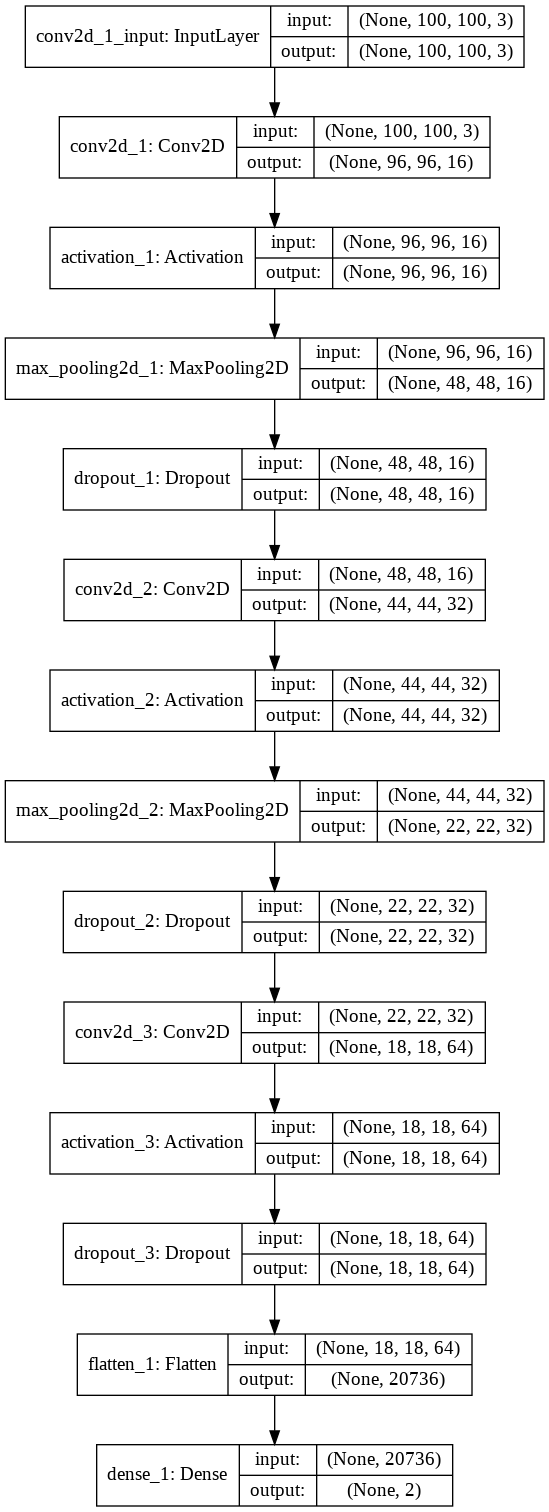

In [0]:
# Model visualization
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### **Case 1: Using both data augmentation methods, without augmenting the test set**



In [0]:
# singan + da; test set not augmented
batch_size = 100
epochs = 50

optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [0]:
#Model fitting
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

In [0]:
# Evaluation on test set- 2nd run
score = model.evaluate(X_test,y_test,verbose=0)
score

[4.322822332382202, 0.6958333333333333, 0.6437499995976562, 0.8655462177600453]

### **Metrics**
**Accuracy: 69.5%**

**Precision: 0.64**

**Recall: 0.86**



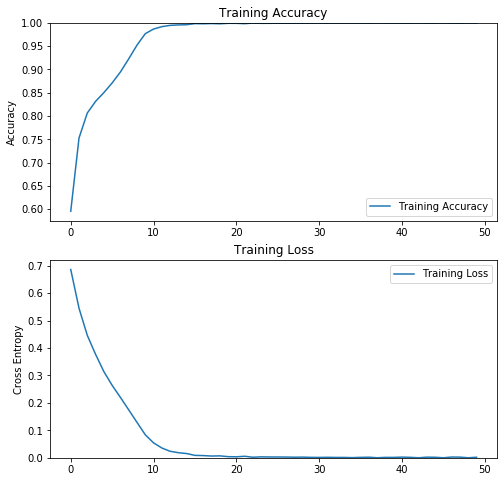

In [0]:
# Accuracy and loss curves
acc = history.history['acc']


loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

#### **Case 2: Using both data augmentation methods, and augmenting test set as well**


In [0]:
# singan + da; test set augmented
batch_size = 100
epochs = 50

optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])

In [0]:
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/50
60/60 [==============================] - 55s 909ms/step - loss: 0.6737 - acc: 0.5980 - precision: 0.6091 - recall: 0.7033
Epoch 2/50
60/60 [==============================] - 54s 905ms/step - loss: 0.5373 - acc: 0.7383 - precision: 0.7321 - recall: 0.8090
Epoch 3/50
60/60 [==============================] - 55s 917ms/step - loss: 0.4670 - acc: 0.7680 - precision: 0.7590 - recall: 0.8326
Epoch 4/50
60/60 [==============================] - 55s 909ms/step - loss: 0.4278 - acc: 0.7816 - precision: 0.7717 - recall: 0.8431
Epoch 5/50
60/60 [==============================] - 55s 909ms/step - loss: 0.4006 - acc: 0.7944 - precision: 0.7832 - recall: 0.8537
Epoch 6/50
60/60 [==============================] - 54s 907ms/step - loss: 0.3806 - acc: 0.8061 - precision: 0.7959 - recall: 0.8595
Epoch 7/50
60/60 [==============================] - 55s 919ms/step - loss: 0.3602 - acc: 0.8201 - precision: 0.8084 - recall: 0.8718
Epoch 8/50
60/60 [==============================] - 54s 895ms/step - 

In [0]:
# Evaluation on test set - 2nd run
score = model.evaluate(X_test,y_test,verbose=0)
score

[0.07157495578938218,
 0.9781746031746031,
 0.9715976330211128,
 0.9891566263868486]

### **Metrics**
**Accuracy: 97.8%**

**Precision: 0.97**

**Recall: 0.98**


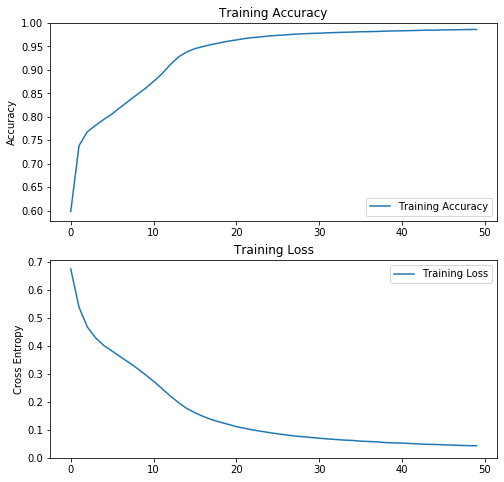

In [0]:
# Accuracy and loss curves
acc = history.history['acc']


loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

#### **Case 3: Using only SinGAN, and augmenting test set as well**

In [0]:
# singan only; test set augmented
batch_size = 32
epochs = 50

optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])

In [0]:
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/50
31/31 [==============================] - 5s 148ms/step - loss: 0.6367 - acc: 0.6314 - precision: 0.6423 - recall: 0.7279
Epoch 2/50
31/31 [==============================] - 4s 121ms/step - loss: 0.4385 - acc: 0.8010 - precision: 0.8167 - recall: 0.8179
Epoch 3/50
31/31 [==============================] - 4s 121ms/step - loss: 0.3368 - acc: 0.8592 - precision: 0.8727 - recall: 0.8677
Epoch 4/50
31/31 [==============================] - 4s 122ms/step - loss: 0.2918 - acc: 0.8853 - precision: 0.8981 - recall: 0.8901
Epoch 5/50
31/31 [==============================] - 4s 121ms/step - loss: 0.2564 - acc: 0.9045 - precision: 0.9108 - recall: 0.9139
Epoch 6/50
31/31 [==============================] - 4s 122ms/step - loss: 0.2323 - acc: 0.9186 - precision: 0.9211 - recall: 0.9300
Epoch 7/50
31/31 [==============================] - 4s 122ms/step - loss: 0.2077 - acc: 0.9284 - precision: 0.9255 - recall: 0.9444
Epoch 8/50
31/31 [==============================] - 4s 121ms/step - loss: 0.

In [0]:
# Evaluation on test set: 2nd run
score = model.evaluate(X_test,y_test,verbose=0)
score

[0.03322909125196626, 0.9916666666666667, 0.9842519677289355, 0.9999999992]

### **Metrics**
**Accuracy: 99.1%**

**Precision: 0.98**

**Recall: 0.99**


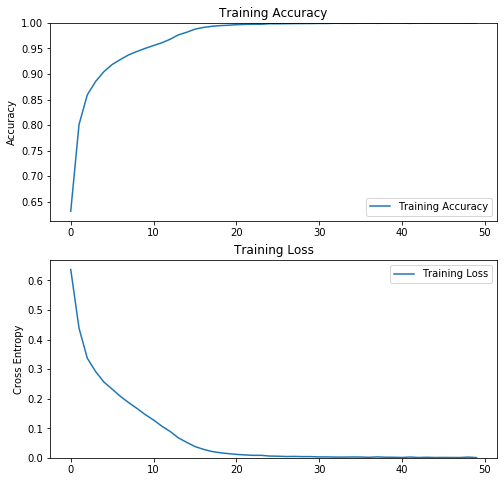

In [0]:
# Accuracy and loss plots
acc = history.history['acc']


loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()

#### **Case 4: Using only SinGAN, test set unaugmented**

In [0]:
# singan only; test set not augmented
batch_size = 32
epochs = 50

optimizer = keras.optimizers.rmsprop(lr = 0.0001, decay = 1e-6)

model.compile(loss = 'binary_crossentropy',optimizer = optimizer, metrics = ['accuracy',keras_metrics.precision(), keras_metrics.recall()])

In [0]:
history = model.fit(X_train,y_train,steps_per_epoch = int(len(X_train)/batch_size),epochs=epochs)
history

Epoch 1/50
31/31 [==============================] - 4s 132ms/step - loss: 0.6618 - acc: 0.6198 - precision: 0.6383 - recall: 0.7127
Epoch 2/50
31/31 [==============================] - 4s 121ms/step - loss: 0.3966 - acc: 0.8194 - precision: 0.8311 - recall: 0.8428
Epoch 3/50
31/31 [==============================] - 4s 121ms/step - loss: 0.2358 - acc: 0.9034 - precision: 0.9167 - recall: 0.9066
Epoch 4/50
31/31 [==============================] - 4s 122ms/step - loss: 0.1492 - acc: 0.9413 - precision: 0.9531 - recall: 0.9396
Epoch 5/50
31/31 [==============================] - 4s 121ms/step - loss: 0.0975 - acc: 0.9634 - precision: 0.9709 - recall: 0.9623
Epoch 6/50
31/31 [==============================] - 4s 121ms/step - loss: 0.0568 - acc: 0.9819 - precision: 0.9857 - recall: 0.9813
Epoch 7/50
31/31 [==============================] - 4s 122ms/step - loss: 0.0292 - acc: 0.9921 - precision: 0.9941 - recall: 0.9916
Epoch 8/50
31/31 [==============================] - 4s 121ms/step - loss: 0.

In [0]:
# Evaluation on test set: 2nd run
score = model.evaluate(X_test,y_test,verbose=0)
score


[3.8665573438008627, 0.75, 0.6705202308262889, 0.9747899151472355]

### **Metrics**
**Accuracy: 75%**

**Precision: 0.67**

**Recall: 0.97**


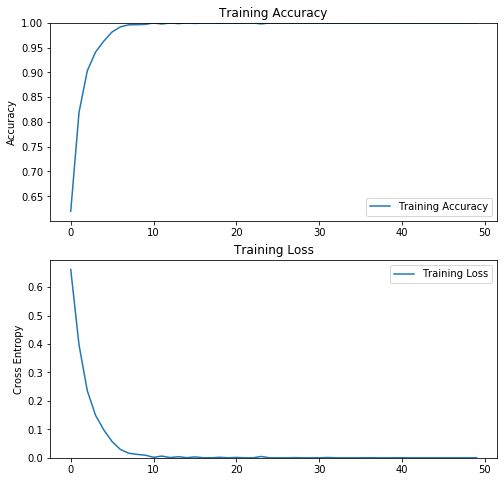

In [0]:
# Accuracy and test plots
acc = history.history['acc']


loss = history.history['loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training Loss')
plt.show()